In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.cm as cm
from sklearn import datasets
from math import *
import seaborn as sns; sns.set_style('white')

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (5, 5)
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.serif'] = 'Times'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['lines.linewidth'] = 1.0
plt = matplotlib.pyplot

In [2]:
# create training set
np.random.seed(7777)
size = 500
train_range = (-10, 10)

X, Y = datasets.make_blobs(n_samples=size, centers=4, cluster_std=1.2, 
                           center_box=train_range, random_state=37)

In [3]:
# construct and train the model
torch.manual_seed(99999)

m, n = X.shape
h = 20  # num. hidden units
k = 4  # num. classes


class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()

        self.feature_extr = nn.Sequential(
            nn.Linear(n, h),
            nn.BatchNorm1d(h),
            nn.ReLU(), 
            nn.Linear(h, h), 
            nn.BatchNorm1d(h),
            nn.ReLU()
        )

        self.clf = nn.Linear(h, k, bias=False)
    
    def forward(self, x):
        x = self.feature_extr(x)
        return self.clf(x)
    
    
X_train = torch.from_numpy(X).float()
y_train = torch.from_numpy(Y).long()
    
model = Model()    
opt = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)

for it in range(5000):
    y = model(X_train)
    l = F.cross_entropy(y, y_train)
    l.backward()
    opt.step()
    opt.zero_grad()
        
print(f'Loss: {l.item():.3f}')

Loss: 0.043


In [4]:
# Test data
size = 50
test_range = (-15, 15)
test_rng = np.linspace(*test_range, size)

X1_test, X2_test = np.meshgrid(test_rng, test_rng)
X_test = np.stack([X1_test.ravel(), X2_test.ravel()]).T
X_test = torch.from_numpy(X_test).float()

In [5]:
# the function to plot the confidence plot
def plot(X, Y, X1_test, X2_test, Z, test_range):
    cmap = 'Blues'
    plt.figure(figsize=(6, 5))

    im = plt.contourf(X1_test, X2_test, Z, alpha=0.7, cmap=cmap, levels=np.arange(0.0, 1.01, 0.1))
    #im = plt.contourf(X1_test, X2_test, Z, alpha=0.7, cmap=cmap, levels=np.arange(0.01, 1.01, 0.1))
    plt.colorbar(im)
    
    plt.scatter(X[Y==0][:, 0], X[Y==0][:, 1], c='coral', edgecolors='k', linewidths=0.5)
    plt.scatter(X[Y==1][:, 0], X[Y==1][:, 1], c='yellow', edgecolors='k', linewidths=0.5)
    plt.scatter(X[Y==2][:, 0], X[Y==2][:, 1], c='yellowgreen', edgecolors='k', linewidths=0.5)
    plt.scatter(X[Y==3][:, 0], X[Y==2][:, 1], c='violet', edgecolors='k', linewidths=0.5)

    plt.xlim(test_range);
    plt.ylim(test_range);
    plt.xticks([]);
    plt.yticks([]);

    plt.show();

In [6]:
# Exact Hessian using PyTorch's autograd. Credits due to Felix Dangel.
from hessian import exact_hessian
from backpack import extend, backpack, extensions
from torch.distributions.multivariate_normal import MultivariateNormal


W = list(model.parameters())[-1]
shape_W = W.shape


# Use BackPACK to get the Kronecker-factored last-layer covariance
extend(model.clf)
loss_func = extend(nn.CrossEntropyLoss(reduction='sum'))

loss = loss_func(model(X_train), y_train)

with backpack(extensions.KFAC()):
    loss.backward()

# The Kronecker-factored Hessian of the negative log-posterior
A, B = W.kfac

# The weight decay used for training is the Gaussian prior's precision
prec0 = 5e-4

# The posterior covariance's Kronecker factors
U = torch.inverse(A + sqrt(prec0)*torch.eye(shape_W[0]))
V = torch.inverse(B + sqrt(prec0)*torch.eye(shape_W[1]))

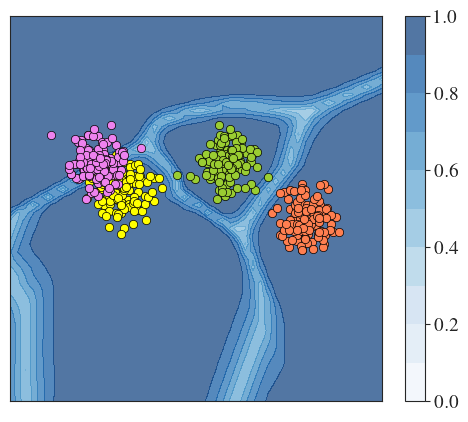

In [7]:
model.eval()

with torch.no_grad():
    py_map = F.softmax(model(X_test), 1).squeeze().numpy()

conf = py_map.max(1)

plot(X, Y, X1_test, X2_test, conf.reshape(size, size), test_range)

torch.Size([2500, 4, 4])


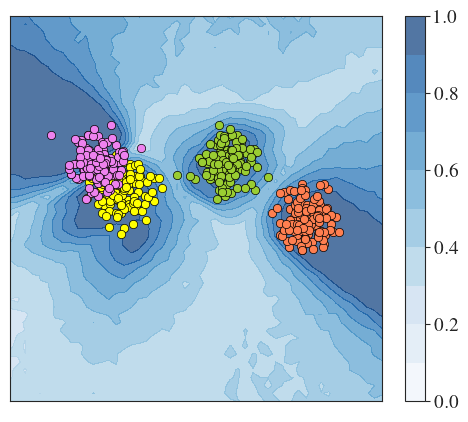

In [8]:
@torch.no_grad()
def predict(x):
    phi = model.feature_extr(x)
    
    # MAP prediction
    m = phi @ W.T
    
    # v is the induced covariance. 
    # See Appendix B.1 of https://arxiv.org/abs/2002.10118 for the detail of the derivation.
    v = torch.diag(phi @ V @ phi.T).reshape(-1, 1, 1) * U
    print(v.shape)
        
    # The induced distribution over the output (pre-softmax)
    output_dist = MultivariateNormal(m, v)

    # MC-integral
    n_sample = 1000
    py = 0

    for _ in range(n_sample):
        out_s = output_dist.rsample()
        py += torch.softmax(out_s, 1)

    py /= n_sample

    return py.numpy()


# Get the posterior covariance and make prediction
py = predict(X_test)

# Confidence
conf = py.max(1)

plot(X, Y, X1_test, X2_test, conf.reshape(size, size), test_range)

In [76]:
def predict_with_sigmoid_bound(x):
    phi = model.feature_extr(x)
    phi.requires_grad_() # Ensure phi tracks gradients

    m = phi @ W.T  # Ensure logits require gradients
    print("m.requires_grad:", m.requires_grad)  # Debugging check

    # Compute \tilde{f}_{\theta, k}(x)
    tilde_f = []
    for k in range(m.shape[1]):  
        mask = torch.arange(m.shape[1]).to(m.device)  # Ensure correct device
        mask = mask[mask != k]  # Get valid indices

        log_sum_exp = torch.logsumexp(m.gather(1, mask.unsqueeze(0).expand(m.shape[0], -1)), dim=-1, keepdim=True)

        tilde_f_k = m[:, k:k+1] - log_sum_exp  

        print(f"tilde_f_k for class {k} requires_grad:", tilde_f_k.requires_grad)  # Debugging check

        tilde_f.append(tilde_f_k)
    
    tilde_f = torch.cat(tilde_f, dim=-1)  

    print("tilde_f requires_grad:", tilde_f.requires_grad)  # Should be True

    # Compute gradients of \tilde{f}_{\theta, k}(x)
    grad_tilde_f = []
    for k in range(m.shape[1]):  
        grad_k = torch.autograd.grad(tilde_f[:, k].sum(), phi, retain_graph=True)[0]
        grad_tilde_f.append(grad_k.norm(dim=-1, keepdim=True))  

    grad_tilde_f = torch.cat(grad_tilde_f, dim=-1)  

    # Compute Hessian-based variance v
    #v = torch.einsum("bk,kj,bj->bk", grad_tilde_f, V, grad_tilde_f) * U  
    #v = (torch.diag(phi @ V @ phi.T).reshape(-1, 1, 1) * U)
    #print(v.shape)


    # Select the smallest entry in v
    #lambda_min_v = v.min(dim=-1, keepdim=True).values 
    #eigenvalues = torch.linalg.eigvalsh(v)  # Compute all eigenvalues for each sample
    #lambda_min_v = eigenvalues.min(dim=-1, keepdim=True).values  # Select the smallest one
    #print(lambda_min_v.shape)

    lambda_max_U = torch.linalg.eigvalsh(U).max()
    lambda_max_V = torch.linalg.eigvalsh(V).max()
    lambda_max_H = lambda_max_U * lambda_max_V
    min_grad_norm_sq = torch.norm(grad_tilde_f, dim=-1, p=2).pow(2).min(dim=-1, keepdim=True).values



    # Compute uncertainty-adjusted scaling
    #uncertainty_scale = 1 + torch.sqrt((torch.pi / 8) * lambda_min_v)
    uncertainty_scale = 1+ torch.sqrt((torch.pi / 8) * lambda_max_H * min_grad_norm_sq)
    # Compute final adjusted logits
    z_k = tilde_f / uncertainty_scale  

    # Compute softmax probabilities
    q_k = torch.sigmoid(z_k)  # Apply sigmoid to each class score
    py = q_k / q_k.sum(dim=-1, keepdim=True)  # Normalize across classes


    return py.detach().numpy()


In [77]:
print(conf)

[0.33517233 0.30134293 0.33092892 ... 0.4403856  0.4621875  0.43568504]


In [142]:
# the function to plot the confidence plot
def plot_concen(X, Y, X1_test, X2_test, Z, test_range):
    cmap = 'Blues'
    plt.figure(figsize=(6, 5))

    im = plt.contourf(X1_test, X2_test, Z, alpha=0.7, cmap=cmap, levels=np.arange(0.001, 0.51, 0.05))
    plt.colorbar(im)
    
    plt.scatter(X[Y==0][:, 0], X[Y==0][:, 1], c='coral', edgecolors='k', linewidths=0.5)
    plt.scatter(X[Y==1][:, 0], X[Y==1][:, 1], c='yellow', edgecolors='k', linewidths=0.5)
    plt.scatter(X[Y==2][:, 0], X[Y==2][:, 1], c='yellowgreen', edgecolors='k', linewidths=0.5)
    plt.scatter(X[Y==3][:, 0], X[Y==2][:, 1], c='violet', edgecolors='k', linewidths=0.5)

    plt.xlim(test_range);
    plt.ylim(test_range);
    plt.xticks([]);
    plt.yticks([]);

    plt.show();

m.requires_grad: True
tilde_f_k for class 0 requires_grad: True
tilde_f_k for class 1 requires_grad: True
tilde_f_k for class 2 requires_grad: True
tilde_f_k for class 3 requires_grad: True
tilde_f requires_grad: True


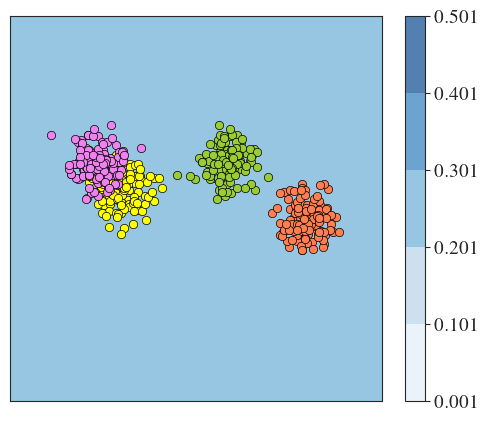

In [79]:
py = predict_with_sigmoid_bound(X_test)
# Get the posterior covariance and make prediction
#py = predict(X_test)

# Confidence
conf = py.max(1)

plot_concen(X, Y, X1_test, X2_test, conf.reshape(size, size), test_range)

Test for different precision

In [253]:
# construct and train the model
torch.manual_seed(99999)

m, n = X.shape
h = 20  # num. hidden units
k = 4  # num. classes
prec0 = 8e-3

class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()

        self.feature_extr = nn.Sequential(
            nn.Linear(n, h),
            nn.BatchNorm1d(h),
            nn.ReLU(), 
            nn.Linear(h, h), 
            nn.BatchNorm1d(h),
            nn.ReLU()
        )

        self.clf = nn.Linear(h, k, bias=False)
    
    def forward(self, x):
        x = self.feature_extr(x)
        return self.clf(x)
    
    
X_train = torch.from_numpy(X).float()
y_train = torch.from_numpy(Y).long()
    
model = Model()    
opt = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay= prec0) # change the weight decay accordingly

for it in range(5000):
    y = model(X_train)
    l = F.cross_entropy(y, y_train)
    l.backward()
    opt.step()
    opt.zero_grad()
        
print(f'Loss: {l.item():.3f}')

Loss: 0.052


In [255]:
# Exact Hessian using PyTorch's autograd. Credits due to Felix Dangel.
from hessian import exact_hessian
from backpack import extend, backpack, extensions
from torch.distributions.multivariate_normal import MultivariateNormal


W = list(model.parameters())[-1]
shape_W = W.shape


# Use BackPACK to get the Kronecker-factored last-layer covariance
extend(model.clf)
loss_func = extend(nn.CrossEntropyLoss(reduction='sum'))

loss = loss_func(model(X_train), y_train)

with backpack(extensions.KFAC()):
    loss.backward()

# The Kronecker-factored Hessian of the negative log-posterior
A, B = W.kfac

# The weight decay used for training is the Gaussian prior's precision
#prec0 = 5e-4
prec0 = 8e-3

# The posterior covariance's Kronecker factors
U = torch.inverse(A + sqrt(prec0)*torch.eye(shape_W[0]))
V = torch.inverse(B + sqrt(prec0)*torch.eye(shape_W[1]))

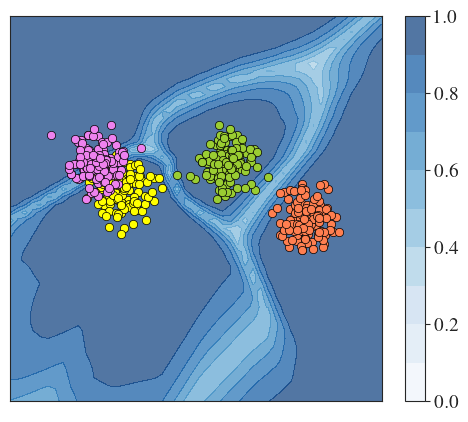

In [256]:
model.eval()

with torch.no_grad():
    py_map = F.softmax(model(X_test), 1).squeeze().numpy()

conf = py_map.max(1)

plot(X, Y, X1_test, X2_test, conf.reshape(size, size), test_range)

In [261]:
def predict_with_sigmoid_bound(x):
    phi = model.feature_extr(x)
    phi.requires_grad_() # Ensure phi tracks gradients

    m = phi @ W.T  # Ensure logits require gradients
    print("m.requires_grad:", m.requires_grad)  # Debugging check

    # Compute \tilde{f}_{\theta, k}(x)
    tilde_f = []
    for k in range(m.shape[1]):  
        mask = torch.arange(m.shape[1]).to(m.device)  # Ensure correct device
        mask = mask[mask != k]  # Get valid indices

        log_sum_exp = torch.logsumexp(m.gather(1, mask.unsqueeze(0).expand(m.shape[0], -1)), dim=-1, keepdim=True)

        tilde_f_k = m[:, k:k+1] - log_sum_exp  

        print(f"tilde_f_k for class {k} requires_grad:", tilde_f_k.requires_grad)  # Debugging check

        tilde_f.append(tilde_f_k)
    
    tilde_f = torch.cat(tilde_f, dim=-1)  

    print("tilde_f requires_grad:", tilde_f.requires_grad)  # Should be True

    # Compute gradients of \tilde{f}_{\theta, k}(x)
    grad_tilde_f = []
    for k in range(m.shape[1]):  
        grad_k = torch.autograd.grad(tilde_f[:, k].sum(), phi, retain_graph=True)[0]
        grad_tilde_f.append(grad_k.norm(dim=-1, keepdim=True))  

    grad_tilde_f = torch.cat(grad_tilde_f, dim=-1)  

    # Compute Hessian-based variance v
    #v = torch.einsum("bk,kj,bj->bk", grad_tilde_f, V, grad_tilde_f) * U  
    #v = (torch.diag(phi @ V @ phi.T).reshape(-1, 1, 1) * U)
    #print(v.shape)


    # Select the smallest entry in v
    #lambda_min_v = v.min(dim=-1, keepdim=True).values 
    #eigenvalues = torch.linalg.eigvalsh(v)  # Compute all eigenvalues for each sample
    #lambda_min_v = eigenvalues.min(dim=-1, keepdim=True).values  # Select the smallest one
    #print(lambda_min_v.shape)

    lambda_max_U = torch.linalg.eigvalsh(U).max()
    lambda_max_V = torch.linalg.eigvalsh(V).max()
    lambda_max_H = lambda_max_U * lambda_max_V
    print(grad_tilde_f.shape)
    print((torch.norm(grad_tilde_f, dim=-1, p=2).pow(2)).shape)
    #min_grad_norm_sq = grad_tilde_f.pow(2).min(dim=-1, keepdim=True).values  # Shape: (batch_size, 1)
    median_grad_norm = torch.median(grad_tilde_f, dim=-1, keepdim=True).values

    #print(min_grad_norm_sq.shape)



    # Compute uncertainty-adjusted scaling
    #uncertainty_scale = 1 + torch.sqrt((torch.pi / 8) * lambda_min_v)
    uncertainty_scale = 1+ torch.sqrt((torch.pi / 8) * lambda_max_H * median_grad_norm)
    # Compute final adjusted logits
    z_k = tilde_f / uncertainty_scale  

    # Compute softmax probabilities
    q_k = torch.sigmoid(z_k)  # Apply sigmoid to each class score
    py = q_k / q_k.sum(dim=-1, keepdim=True)  # Normalize across classes


    return py.detach().numpy()

m.requires_grad: True
tilde_f_k for class 0 requires_grad: True
tilde_f_k for class 1 requires_grad: True
tilde_f_k for class 2 requires_grad: True
tilde_f_k for class 3 requires_grad: True
tilde_f requires_grad: True
torch.Size([2500, 4])
torch.Size([2500])
torch.Size([2500, 1])


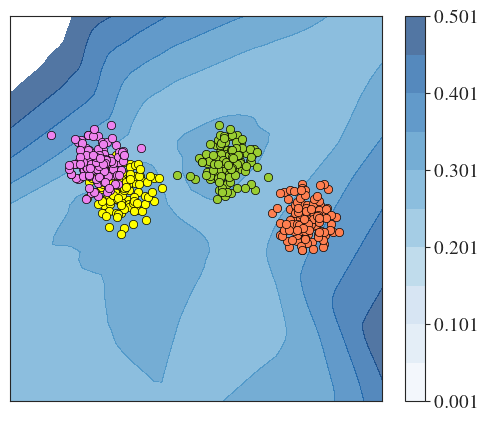

In [259]:
py = predict_with_sigmoid_bound(X_test)
# Get the posterior covariance and make prediction
#py = predict(X_test)

# Confidence
conf = py.max(1)

plot_concen(X, Y, X1_test, X2_test, conf.reshape(size, size), test_range)

m.requires_grad: True
tilde_f_k for class 0 requires_grad: True
tilde_f_k for class 1 requires_grad: True
tilde_f_k for class 2 requires_grad: True
tilde_f_k for class 3 requires_grad: True
tilde_f requires_grad: True
torch.Size([2500, 4])
torch.Size([2500])


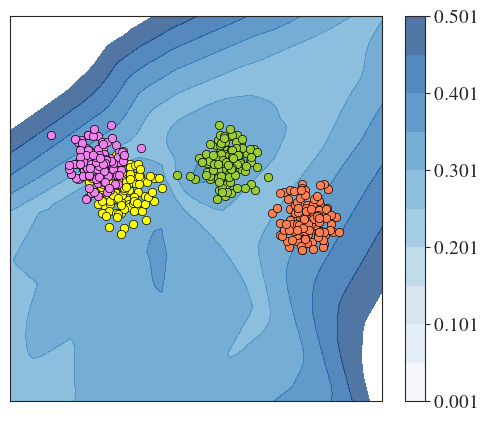

In [262]:
py = predict_with_sigmoid_bound(X_test)
# Get the posterior covariance and make prediction
#py = predict(X_test)

# Confidence
conf = py.max(1)

plot_concen(X, Y, X1_test, X2_test, conf.reshape(size, size), test_range)

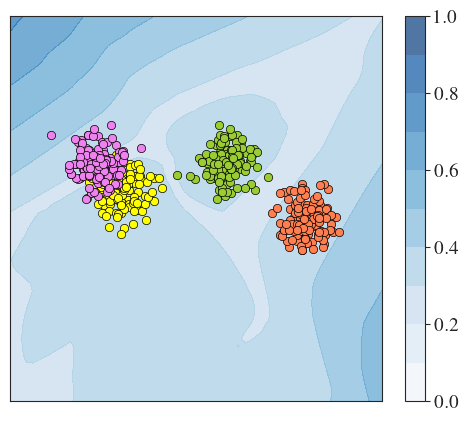

In [263]:
plot(X, Y, X1_test, X2_test, conf.reshape(size, size), test_range)

# **Comparison of Sigmoid-Bound vs. LLLA with Monte Carlo**

## **1. Theoretical Justification**
| Method | Strength | Weakness |
|--------|---------|----------|
| **Sigmoid-Bound Approximation (This Work)** | Preserves an **asymptotic uncertainty bound** using a theoretically motivated correction. Can be applied **deterministically** without the need for sampling. | Introduces a **fixed heuristic** for uncertainty scaling, which may lead to **suboptimal** uncertainty calibration compared to full posterior sampling. |
| **Laplace with Monte Carlo (LLLA)** | Explicitly **models the posterior distribution** over neural network weights and integrates over it via Monte Carlo, producing **more accurate uncertainty estimates**. | **Computationally more expensive** when using full-network Laplace (especially for large models). |

---

## **2. Computational Efficiency**
| Factor | Sigmoid-Bound | LLLA with Monte Carlo |
|--------|--------------|-----------------------|
| **Hessian Computation** | Avoids **explicit Hessian sampling**, only requires a simple **gradient-based rescaling**. | Requires **Hessian approximation** (Kronecker-factored or diagonal), which can be expensive in full-network cases. |
| **Sampling Complexity** | **O(1)** (closed-form transformation applied once). | **O(S)** (Monte Carlo samples from Gaussian posterior). |
| **Scalability** | **Scales well** to large models, since it only needs forward and backward passes. | **Full-network Laplace scales poorly**, especially if the Hessian is large. |
| **Memory Usage** | Minimal additional memory overhead. | Requires storing posterior covariance \( \Sigma \) and multiple samples. |

✔️ **Advantage of Sigmoid-Bound:** Faster inference, can scale better in large networks.  
✔️ **Advantage of LLLA:** More precise uncertainty estimation, but may become computationally expensive.

---

## **3. Uncertainty Calibration**
| Factor | Sigmoid-Bound | LLLA with Monte Carlo |
|--------|--------------|-----------------------|
| **Preserving Softmax Behavior** | **Forces probabilities closer to 1/K for OOD samples**, but may distort well-calibrated uncertainty in ID regions. | **Softmax structure is preserved**, allowing uncertainty to naturally emerge via sampling. |
| **Overconfidence Handling** | Explicitly constrains confidence through an upper bound. | Reduces confidence through posterior variance but retains expressivity. |
| **Decision Boundary Preservation** | **Ensures decision boundaries remain unchanged** analytically. | Monte Carlo samples do **not guarantee exact decision boundary preservation** but still align well in practice. |

✔️ **Advantage of Sigmoid-Bound:** Provides an explicit **theoretical bound** on overconfidence.  
✔️ **Advantage of LLLA:** More **adaptive** to different datasets and more robust for **calibration**.

---

## **4. Practical Considerations**
| Factor | Sigmoid-Bound | LLLA with Monte Carlo |
|--------|--------------|-----------------------|
| **Ease of Implementation** | Simple to apply as a post-processing step to logits. | Requires computing the posterior covariance \( \Sigma \) and sampling from it. |
| **Performance on Large Networks** | More efficient for large models **when full-network Laplace is intractable**. | Performs well when using **only last-layer Laplace** but may struggle with **full-network Laplace**. |
| **Tuning Sensitivity** | Heavily depends on **choice of prior precision** and **gradient scaling heuristic**. | More robust since it learns prior precision via **marginal likelihood optimization**. |

✔️ **Advantage of Sigmoid-Bound:** Simpler to implement, can be applied as a lightweight **post-processing step**.  
✔️ **Advantage of LLLA:** More principled and better calibrated, especially in **small to medium-sized models**.

---

## **5. When to Use Which?**
| Scenario | Preferred Method |
|----------|-----------------|
| **Last-layer Laplace (LLLA)** | ✅ **LLLA with Monte Carlo** (Monte Carlo is cheap here). |
| **Full-network Laplace (Large Models)** | ✅ **Sigmoid-Bound Approximation** (Avoids expensive Hessian sampling). |
| **Low-resource settings (Embedded devices, fast inference required)** | ✅ **Sigmoid-Bound Approximation** (Computationally cheaper). |
| **Best Uncertainty Estimation for OOD detection** | ✅ **LLLA with Monte Carlo** (More expressive uncertainty estimates). |
| **Analytical Control of Confidence** | ✅ **Sigmoid-Bound Approximation** (Gives a strict overconfidence bound). |

---

## **6. Final Conclusion**
- **If the Hessian is cheap (last-layer Laplace), Monte Carlo is clearly superior** because it better models uncertainty.
- **If full-network Laplace is used**, then **Hessian computation becomes expensive**, and a heuristic correction like **Sigmoid-Bound** might be a **viable alternative**.
- **For practical applications**, **LLLA should be preferred whenever computational resources allow**, while **Sigmoid-Bound is an efficient fallback** when scaling up.

---

This gives a **clear trade-off** between **precision vs. efficiency**, making **LLLA ideal when feasible**, but **Sigmoid-Bound a reasonable alternative in large-scale settings**. 🚀


In [175]:
# construct and train the model
torch.manual_seed(99999)

m, n = X.shape
h = 20  # num. hidden units
k = 4  # num. classes
prec0 = 5e-4

class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()

        self.feature_extr = nn.Sequential(
            nn.Linear(n, h),
            nn.BatchNorm1d(h),
            nn.ReLU(), 
            nn.Linear(h, h), 
            nn.BatchNorm1d(h),
            nn.ReLU()
        )

        self.clf = nn.Linear(h, k, bias=False)
    
    def forward(self, x):
        x = self.feature_extr(x)
        return self.clf(x)
    
    
X_train = torch.from_numpy(X).float()
y_train = torch.from_numpy(Y).long()
    
model = Model()    
opt = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay= prec0) # change the weight decay accordingly

for it in range(5000):
    y = model(X_train)
    l = F.cross_entropy(y, y_train)
    l.backward()
    opt.step()
    opt.zero_grad()
        
print(f'Loss: {l.item():.3f}')

Loss: 0.043


In [177]:
# Exact Hessian using PyTorch's autograd. Credits due to Felix Dangel.
from hessian import exact_hessian
from backpack import extend, backpack, extensions
from torch.distributions.multivariate_normal import MultivariateNormal


W = list(model.parameters())[-1]
shape_W = W.shape


# Use BackPACK to get the Kronecker-factored last-layer covariance
extend(model.clf)
loss_func = extend(nn.CrossEntropyLoss(reduction='sum'))

loss = loss_func(model(X_train), y_train)

with backpack(extensions.KFAC()):
    loss.backward()

# The Kronecker-factored Hessian of the negative log-posterior
A, B = W.kfac

# The weight decay used for training is the Gaussian prior's precision
#prec0 = 5e-4
prec0 = 5e-4

# The posterior covariance's Kronecker factors
U = torch.inverse(A + sqrt(prec0)*torch.eye(shape_W[0]))
V = torch.inverse(B + sqrt(prec0)*torch.eye(shape_W[1]))

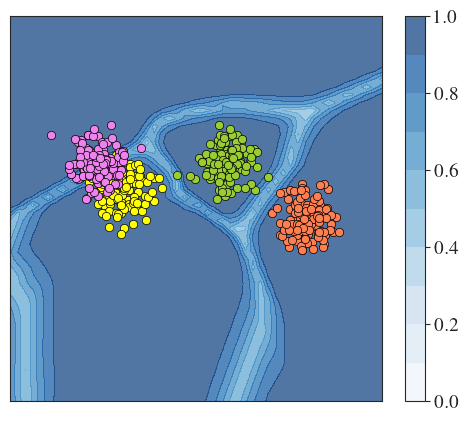

In [178]:
model.eval()

with torch.no_grad():
    py_map = F.softmax(model(X_test), 1).squeeze().numpy()

conf = py_map.max(1)

plot(X, Y, X1_test, X2_test, conf.reshape(size, size), test_range)

In [9]:
from scipy.spatial.distance import cdist

def kernel_distance(x, X_train, kernel='rbf', gamma=None):
    """
    Computes kernel-based distance between test inputs x and training set X_train.
    
    - If kernel='rbf', applies Gaussian RBF kernel.
    - If kernel='linear', applies standard dot-product similarity.
    """
    distances = cdist(x, X_train, metric='euclidean')  # Ensure correct shape (N_test, N_train)
    print(distances)
    
    if kernel == 'rbf':
        if gamma is None:
            gamma = 1.0 / X_train.shape[1]  # Default gamma = 1 / num_features
        K = np.exp(-gamma * distances ** 2)  # RBF kernel
    
    elif kernel == 'linear':
        K = np.dot(x, X_train.T)  # Linear kernel
    
    # Normalize across all training points
    return 1 / (np.sum(K, axis=1, keepdims=True))  # Shape (N_test, 1)


In [257]:
from scipy.spatial.distance import pdist
def adaptive_gamma(X_train):
    pairwise_distances = pdist(X_train, metric='euclidean')
    median_dist = np.median(pairwise_distances)
    return 1.0 / (2 * median_dist**2)  # Standard RBF heuristic


from scipy.spatial.distance import cdist

def kernel_distance(x, X_train, kernel='rbf', gamma=None):
    """
    Computes kernel-based distance between test inputs x and training set X_train.
    
    - If kernel='rbf', applies Gaussian RBF kernel.
    - If kernel='linear', applies standard dot-product similarity.
    """
    distances = cdist(x, X_train, metric='euclidean')  # Ensure correct shape (N_test, N_train)
    print(distances)
    
    if kernel == 'rbf':
        if gamma is None:
            gamma = 1.0 / X_train.shape[1]  # Default gamma = 1 / num_features
        K = np.exp(-gamma * distances ** 2)  # RBF kernel
    
    elif kernel == 'linear':
        K = np.dot(x, X_train.T)  # Linear kernel
    
    # Normalize across all training points
    return 1 / (1 + np.sum(K, axis=1, keepdims=True))  # Shape (N_test, 1)


@torch.no_grad()
def predict_with_kernel_bound(x, X_train):
    phi = model.feature_extr(x)

    # MAP prediction
    m = phi @ W.T  # Logits

    # Compute \tilde{f}_{\theta, k}(x)
    tilde_f = []
    for k in range(m.shape[1]):  
        mask = torch.arange(m.shape[1], device=m.device)  # Ensure correct device
        mask = mask[mask != k]  # Get valid indices
        log_sum_exp = torch.logsumexp(m.gather(1, mask.unsqueeze(0).expand(m.shape[0], -1)), dim=-1, keepdim=True)
        tilde_f_k = m[:, k:k+1] - log_sum_exp  
        tilde_f.append(tilde_f_k)

    tilde_f = torch.cat(tilde_f, dim=-1)  
    
    lambda_max_U = torch.linalg.eigvalsh(U).max()
    lambda_max_V = torch.linalg.eigvalsh(V).max()
    lambda_max_H = lambda_max_U * lambda_max_V

    # Compute kernel-based uncertainty scaling
    print(adaptive_gamma(X_train))
    kernel_scale = kernel_distance(x, X_train, kernel='rbf', gamma= 0.03)
    print(kernel_scale)
    
    #uncertainty_scale
    uncertainty_scale = 1+ torch.sqrt((torch.pi / 8) * lambda_max_H * kernel_scale)
    # Compute final adjusted logits
    z_k = tilde_f / uncertainty_scale 

    # Compute softmax probabilities
    q_k = torch.sigmoid(z_k)  
    py = q_k / q_k.sum(dim=-1, keepdim=True)  

    return py.cpu().numpy()


0.007236332243649216
[[20.7926844  27.65791963 22.29499082 ... 27.6173447  28.72638145
  19.90515081]
 [20.61612686 27.25616459 22.06652452 ... 27.09416699 28.19723379
  19.55929146]
 [20.45637618 26.86235567 21.85282741 ... 26.57479419 27.67151309
  19.22671068]
 ...
 [24.69352432 13.97897712 22.28301008 ... 16.59300533 16.15451619
  22.09760726]
 [25.25261276 14.44247601 22.83928125 ... 16.79104806 16.31204172
  22.58075366]
 [25.81411248 14.91670515 23.39834709 ... 17.00883421 16.49080642
  23.07002988]]
[[0.99286936]
 [0.99043893]
 [0.98745159]
 ...
 [0.86594227]
 [0.89701237]
 [0.92219178]]


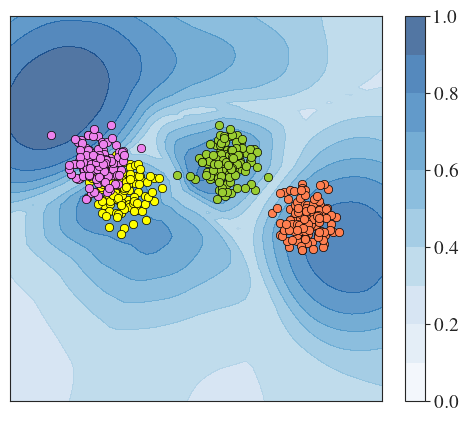

In [258]:
py = predict_with_kernel_bound(X_test, X_train)

# Confidence
conf = py.max(1)

plot(X, Y, X1_test, X2_test, conf.reshape(size, size), test_range)

torch.Size([2500, 4, 4])
[[20.7926844  27.65791963 22.29499082 ... 27.6173447  28.72638145
  19.90515081]
 [20.61612686 27.25616459 22.06652452 ... 27.09416699 28.19723379
  19.55929146]
 [20.45637618 26.86235567 21.85282741 ... 26.57479419 27.67151309
  19.22671068]
 ...
 [24.69352432 13.97897712 22.28301008 ... 16.59300533 16.15451619
  22.09760726]
 [25.25261276 14.44247601 22.83928125 ... 16.79104806 16.31204172
  22.58075366]
 [25.81411248 14.91670515 23.39834709 ... 17.00883421 16.49080642
  23.07002988]]
torch.Size([2500, 1, 1])
torch.Size([2500, 4, 4])


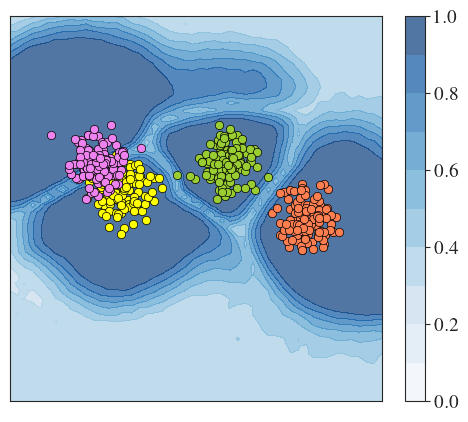

In [34]:
@torch.no_grad()
def predict(x):
    phi = model.feature_extr(x)
    
    # MAP prediction
    m = phi @ W.T
    
    # v is the induced covariance. 
    # See Appendix B.1 of https://arxiv.org/abs/2002.10118 for the detail of the derivation.
    v = torch.diag(phi @ V @ phi.T).reshape(-1, 1, 1) * U
    print(v.shape)

    kernel_scale = kernel_distance(x, X_train, kernel='rbf', gamma= .06)
    # Convert to PyTorch tensor with the correct dtype and device
    kernel_scale = torch.tensor(kernel_scale, dtype=v.dtype, device=v.device)
    kernel_scale = kernel_scale.unsqueeze(-1)  # Shape: (batch_size, 1, 1)
    print(kernel_scale.shape)

    scaled_v = (kernel_scale * v)  # Now, (batch_size, num_classes, num_classes)
    print((scaled_v).shape)
        
    # The induced distribution over the output (pre-softmax)
    output_dist = MultivariateNormal(m, scaled_v)

    # MC-integral
    n_sample = 1000
    py = 0

    for _ in range(n_sample):
        out_s = output_dist.rsample()
        py += torch.softmax(out_s, 1)

    py /= n_sample

    return py.numpy()


# Get the posterior covariance and make prediction
py = predict(X_test)

# Confidence
conf = py.max(1)

plot(X, Y, X1_test, X2_test, conf.reshape(size, size), test_range)